In [169]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn import preprocessing

import change_detection
import queue

## Data setup

### 1. Data import

In [170]:
def check_sampling(df_1: pd.DataFrame, df_2: pd.DataFrame) -> bool:
    """_summary_

    Args:
        df_1 (pd.DataFrame): _description_
        df_2 (pd.DataFrame): _description_

    Returns:
        bool: _description_
    """
    timedelta_1 = list(pd.Series(df_1.index).shift(-1) - pd.Series(df_1.index))[0]
    timedelta_2 = list(pd.Series(df_2.index).shift(-1) - pd.Series(df_2.index))[0]

    # If sampling of the first dataframe is sparser return true
    if timedelta_1 < timedelta_2: return True
    # Else false
    return False

In [171]:
def preprocess_csv(csv_path, date_column,  delimiter=',', freq='5min', int_method='linear'):
    """_summary_

    Args:
        csv_path (_type_): _description_
        date_column (_type_): _description_
        delimiter (str, optional): _description_. Defaults to ','.
        freq (str, optional): _description_. Defaults to '5min'.
        int_method (str, optional): _description_. Defaults to 'linear'.

    Returns:
        _type_: _description_
    """


    # Read csv
    df = pd.read_csv(csv_path, delimiter=delimiter)
    date_format = '%d/%m/%Y %H:%M:%S'
        

    # Format the original df
    df.index = pd.to_datetime(df[date_column], format=date_format)
    date_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq=freq)
    df.drop(columns=date_column, inplace=True)

    # Format the new df
    df_new = pd.DataFrame({date_column: date_index})
    df_new.index = df_new[date_column]
    df_new.drop(columns=date_column, inplace=True)

    # Check sampling
    if check_sampling(df, df_new):
        df.resample(freq).mean()

    # Fill the missing dates    
    df_full = df.merge(df_new, how='right', left_index=True, right_index=True)
    df_full = df_full.interpolate(method=int_method)

    X = df_full.values

    # Scale the data
    scaler = preprocessing.StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return pd.DataFrame(data=X_scaled, columns=df_full.columns, index=date_index)

In [172]:
df = preprocess_csv('data\Output_cigre_B1.csv', 'date', freq='5min')

### 2. Additional functions

In [173]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size//2:]

In [174]:
def standardize(x):
    return (x - np.average(x)) / np.std(x)

In [175]:
def rolling_avg(x, n):
    return np.array([np.average(x[i-n//2:i+n//2]) for i in np.arange(n//2, len(x)-n//2)])

In [176]:
def diff(x):
    return np.array(x[1:]-np.roll(x, 1)[1:])

### Test

In [177]:
# It automatically remembers the state 
def x_generator(x):
    for x_i in x:
        yield x_i


- first init
- while loop until false is found
- point detection? or assume very small sequence length?
- **allocation** - next step
- reinit (should a lookback be allowed?)
- back to 2

for now somehow count the loop iterator? The total n? or allow for full?

In [178]:
FITTING_WINDOW = 12
SEQUENCE_WINDOW = 3
seq = FITTING_WINDOW // SEQUENCE_WINDOW

cdt = change_detection.ChangeDetectionTest(FITTING_WINDOW, SEQUENCE_WINDOW)
gen = x_generator(df.T_f.values)

# Initial fit
fit_list = [next(gen) for _ in range(FITTING_WINDOW)]
cdt.fit(fit_list)

In [179]:
from collections import deque

changes = []
fit_end = []
LOOKBACK_WINDOW = 6
lookback_queue = deque(maxlen=LOOKBACK_WINDOW)

# For now a simple solution
while True:
    try:
        
        while True:
            seq += 1

            # Generate new sequence and add it to lookback window
            sequence = [next(gen) for _ in range(SEQUENCE_WINDOW)]
            lookback_queue.extend(sequence)
            cdt.n_sequences += 1

            if not cdt(sequence):
                break

        # Verify the window ??          
        changes.append((seq-1)*SEQUENCE_WINDOW)

        # REFIT

        # Lookback in refit
        # Define the newly added values and complete it with the queue content to obtain fitting window lenght
        fit_list_newadded = [next(gen) for _ in range(FITTING_WINDOW - LOOKBACK_WINDOW)]
        fit_list_complete = list(lookback_queue)
        fit_list_complete.extend(fit_list_newadded)
        # Repopulate the queue 
        lookback_queue.extend(fit_list_complete)
        
        # Reset the number of sequences for value calculation
        cdt.n_sequences = FITTING_WINDOW // SEQUENCE_WINDOW
        # Refit
        cdt.fit(fit_list)
        seq += (FITTING_WINDOW-LOOKBACK_WINDOW) // SEQUENCE_WINDOW
        fit_end.append((seq-1)*SEQUENCE_WINDOW)


    except StopIteration:
        break

In [180]:
cdt.n_sequences

5

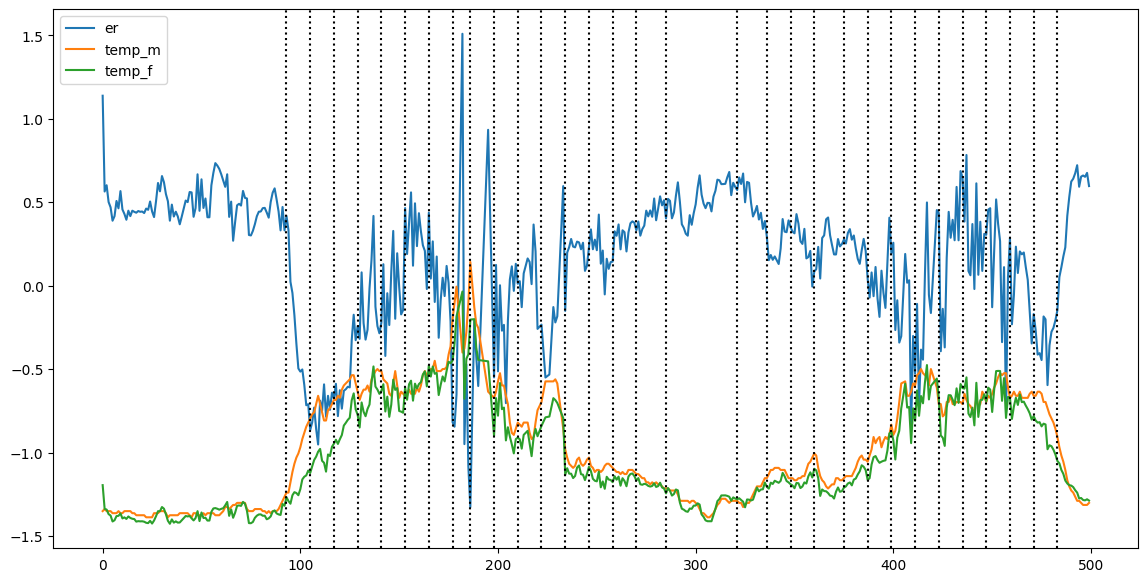

In [181]:
plt.figure(figsize=(14, 7))
plt.plot(df.errore.values[:500], label='er')
plt.plot(df.T_m.values[:500], label='temp_m')
plt.plot(df.T_f.values[:500], label='temp_f')
for value in changes:
    if value > 500:
        break
    plt.axvline(value, linestyle=':', c='k')
# for value in fit_end:
#     if value > 500:
#         break
#     plt.axvline(value, linestyle=':', c='r', alpha = 0.4)

plt.legend()
plt.show()

0. Check the change logic in the paper (which sequence should be called)

1. Verification with CPD ?

2. Lookback in refit ? DONE

3. Tomorrow do actual forecasts with ML models to test what happens in that case (n_params? up to 1000?).
    - LSTM
    - Dense
    - CNN 1D
    - GRU
    - Wavenet?
    - LSTnet?

Min 3 layer

4. What variable should we inspect? (pred or error)

5. Sensitivity analysis on the window? (60m-15m)

### Not standardised test

In [182]:
error_unstd = pd.read_csv('data\Output_cigre_B1.csv', index_col=[0]).errore.values

In [183]:
FITTING_WINDOW = 12
SEQUENCE_WINDOW = 3
seq = FITTING_WINDOW // SEQUENCE_WINDOW

cdt = change_detection.ChangeDetectionTest(FITTING_WINDOW, SEQUENCE_WINDOW)
gen = x_generator(error_unstd)


fit_list = [next(gen) for _ in range(FITTING_WINDOW)]
cdt.fit(fit_list)

In [184]:
changes_new = []
while True:
    try:
        
        while cdt([next(gen) for _ in range(SEQUENCE_WINDOW)]):
            seq += 1
        changes_new.append((seq-1)*SEQUENCE_WINDOW)
        

        # Lookback ??
        fit_list = [next(gen) for _ in range(FITTING_WINDOW)]
        cdt.fit(fit_list)
        seq += FITTING_WINDOW // SEQUENCE_WINDOW

    except StopIteration:
        break

c:\Users\macie\.conda\envs\test_env\Lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


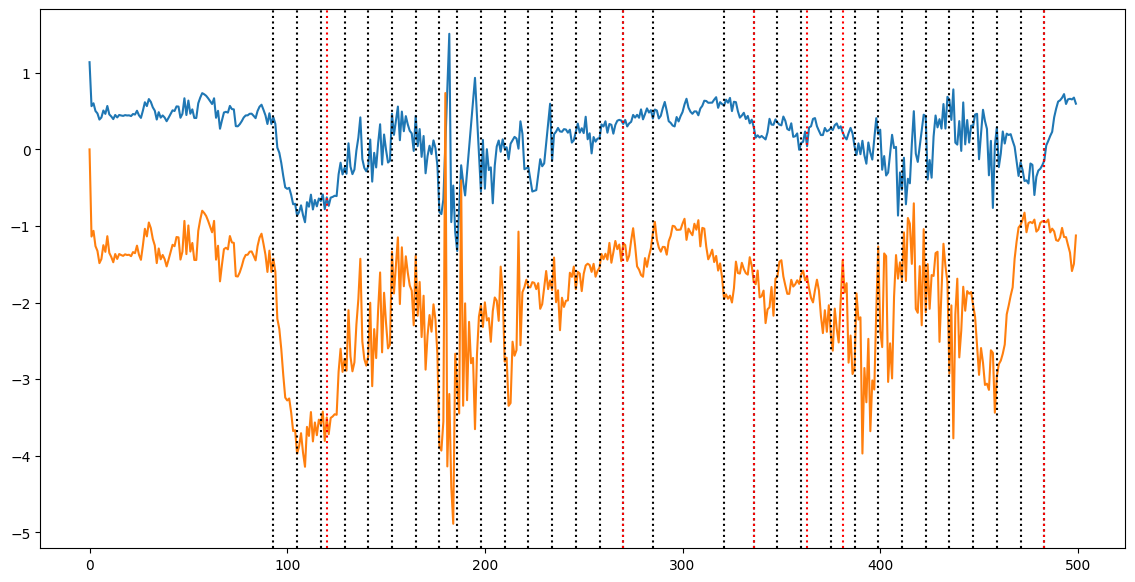

In [185]:
plt.figure(figsize=(14, 7))
plt.plot(df.errore.values[:500])
plt.plot(error_unstd[:500])
for value in changes:
    if value > 500:
        break
    plt.axvline(value, linestyle=':', c='k')
for value in changes_new:
    if value > 500:
        break
    plt.axvline(value, linestyle=':', c='r')

### Temp test

In [186]:
variable = (pd.read_csv('data\Output_cigre_B1.csv', index_col=[0]).T_f.values - np.mean(pd.read_csv('data\Output_cigre_B1.csv', index_col=[0]).T_f.values) ) / np.std(pd.read_csv('data\Output_cigre_B1.csv', index_col=[0]).T_f.values)

In [187]:
FITTING_WINDOW = 24
SEQUENCE_WINDOW = 6
seq = FITTING_WINDOW // SEQUENCE_WINDOW

cdt = change_detection.ChangeDetectionTest(FITTING_WINDOW, SEQUENCE_WINDOW)
gen = x_generator(variable)


fit_list = [next(gen) for _ in range(FITTING_WINDOW)]
cdt.fit(fit_list)

In [188]:
changes = []
while True:
    try:
        
        while cdt([next(gen) for _ in range(SEQUENCE_WINDOW)]):
            seq += 1
        changes.append((seq-1)*SEQUENCE_WINDOW)
        
        # Lookback ??
        fit_list = [next(gen) for _ in range(FITTING_WINDOW)]
        cdt.fit(fit_list)
        seq += FITTING_WINDOW // SEQUENCE_WINDOW

    except StopIteration:
        break

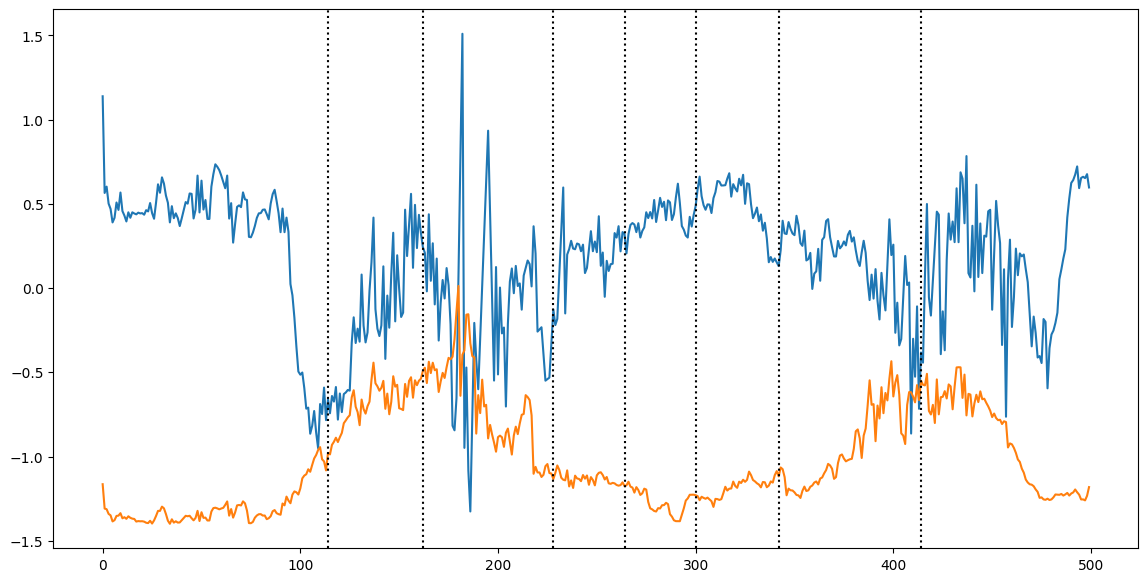

In [189]:
plt.figure(figsize=(14, 7))
plt.plot(df.errore.values[:500])
plt.plot(variable[:500])
for value in changes:
    if value > 500:
        break
    plt.axvline(value, linestyle=':', c='k')

